# Correlation complications and Monte Carlo methods

When we left off last time, we were about to attempt to deal with the consequences of the non-independence of our data when calculating the significance value of Pearson's correlation.  When the values in our dataset are not independent of one another, this can bias our estimate of the significance of any correlation ($p$) and also potentially be misleading about the effect size ($r$).  Let's create some random Gaussian series of numbers and see how various forms of non-independence can affect them.

First, let's get some libraries imported and see how we can create random numbers:

In [1]:
import numpy as np # import Numpy as np
import pandas as pd # import Pandas as pd
import scipy as sp # Import Scipy as sp
import matplotlib.pyplot as plt # get the plotting functionality from Matplotlib

# you can omit the line below if you'd like, but I really don't like the default fonts in Python, so I switch to Helvetica
# plt.rcParams['font.family'] = 'Helvetica'

Recall that if our data points are not truly independent, this can bias our assessment of significance toward being too liberal (e.g. a Type 1 error).  Non-independence (especially if we think about it in _time_) manifests as auto-correlation (correlation between values in the data and other values in the same data) - In time series, we'll call this _serial_ autocorrelation :that consecutive values are not simply random draws from a distribution but rather are influenced in part by values that came before.  We can write a simple 1st order autocorrelation relationship as: 

$
X_{t} = \alpha_{1} X_{t-1} + Z_{t}
$

Or, for every given value $x$, that value is in part determined by the value that preceded it.  Now, let's think again about the equation for the t-statistic:

$
t = r \sqrt{\frac{n-2}{1-r^2}}
$

The $n$ is not simply the sample size, but rather accounts for how many degrees of freedom we have.  In situations where the values in our datasets are not independent, we have _fewer_ degrees of freedom than we have samples, and not accounting for this means that our $n$ is too large and therefore our $p$ will over-estimate the probability of rejecting the null hypothesis. 

Let's write a function to do a very simple calculation of the self- (auto) correlation in a time series.  We'll do that simply by creating a copy of the series and sliding (or lagging) it relative to itself, and calculating the correlation: 

In [8]:
def lagged_autocorrelation(series, lag=1): # default is lag of 1 - note, lag of zero will give an error here - how would you improve this function to avoid that? 
    # Calculate the Pearson correlation coefficient between the series and its lagged version (lag=1 is my default)
    return  sp.stats.pearsonr(series[:-lag], series[lag:])[0] # returns correlation only with [0]

That function will now allow us to estimate the first order autocorrelation of a series (defaulting to the 1st lag), $\rho_1$:

$
\rho_1 = \frac{\sum_{t=1}^{N-1} (X_t - \bar{X})(X_{t+1} - \bar{X})}{\sum_{t=1}^{N} (X_t - \bar{X})^2}
$



Let's now create some autocorrelated series now using the equation:

$
X_{t} = \alpha_{1} X_{t-1} + Z_{t}
$

Here we are creating synthetic or surrogate datasets to use for our lesson - we'll hear these terms more later.

In [2]:
# Set a 'random' seed to a specific number -- my age -- for reproducibility so we all get the same thing
np.random.seed(1999) # Prince's 1982 album with such tracks as '1999' and 'Little Red Corvette'

# Parameters for the autoregressive equation we'll write
n = 128  # once again, length of the time series
alpha1 = 0.9  # an autocorrelation coefficient (0 < alpha < 1)
alpha2 = 0.7  # another autocorrelation coefficient (0 < alpha < 1)

# Generate the first time series with autocorrelation
xa = np.zeros(n)
xa[0] = np.random.normal()  # Initialize the first value from the random normal
for t in range(1, n): # loop over the length of the series, determining the next value from the combination of the autocorrelation and another random number
    xa[t] = alpha1 * xa[t-1] + np.random.normal()

# Generate the second time series with autocorrelation like above
ya = np.zeros(n)
ya[0] = np.random.normal() 
for t in range(1, n):
    ya[t] = alpha2 * ya[t-1] + np.random.normal()

We now have two time series, $xa$ and $ya$ that have a degree of autocorrelation (although different for each one) - let's see what that actually looks like:

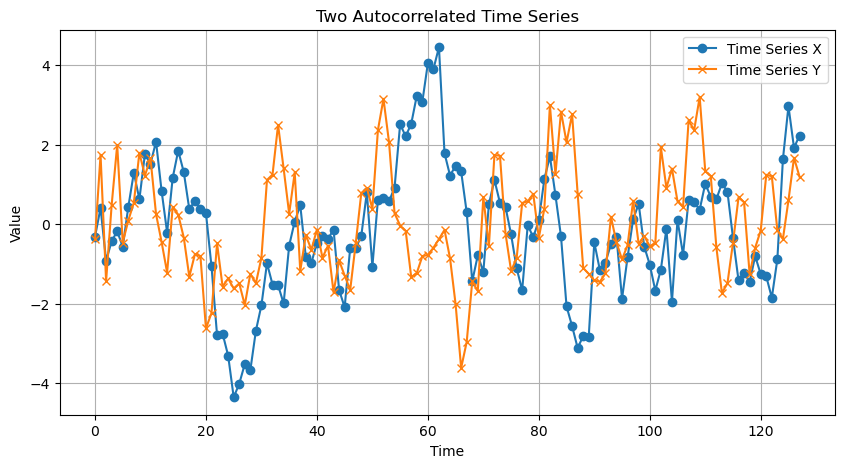

In [3]:
# Plot the two time series
plt.figure(figsize=(10, 5))

plt.plot(xa, label='Time Series X', linestyle='-', marker='o')
plt.plot(ya, label='Time Series Y', linestyle='-', marker='x')

plt.title('Two Autocorrelated Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
rho1 = sp.stats.pearsonr(xa,ya) 
rho1

PearsonRResult(statistic=0.13092252240122876, pvalue=0.14074105991852737)

There is a very slight association (but still $p>0.05$).  If we generated enough different time series, we might find that eventually we get 'lucky' and find a set that are significantly correlated (which, remember, is one of the things we're scared of).  But for our purposes in the next section, all we need is to keep our eye on that p-value.

## Rolling your own correlation for reduced degrees of freedom

The function below will take two time series and the degrees of freedom.  If you thought there was no meaningful autocorrelation, you might make the effective sample size $N_{eff}$ the same as the actual sample size.  But as we'll see, we can pass this function a penalized 'effective' sample size to account for autocorrelation.  

In [5]:
def my_correlation_function(x,y,neff):
    dof = neff - 2
    correlation_matrix = np.corrcoef(x, y)
    correlation_value = correlation_matrix[0, 1] #taking an off-diagonal correlation value = the r
    t_statistic = (correlation_value * np.sqrt(dof)) / np.sqrt(1 - correlation_value**2)
    p_value = 2 * (1 - sp.stats.t.cdf(abs(t_statistic), df=dof)) 
    return correlation_value, p_value

Let's make sure we get the same answer as Scipy:

In [6]:
my_correlation_function(xa,ya,np.size(xa))

(0.1309225224012287, 0.1407410599185277)

Yup! Looks like we did an OK job rolling our own!

We're going to use a calculation of the effective samples size $N_{eff}$ from [Thiebaux and Zwiers 1984](https://journals.ametsoc.org/view/journals/apme/23/5/1520-0450_1984_023_0800_tiaeoe_2_0_co_2.xml), although it has also been described and articulated elsewhere.  The effective sample size is the sample size times the ratio of 1 less the product of the 1st order autocorrelation over 1 plus the product of the 1st order autocorrelations.  The effect here will be that the larger the autocorrelation, the smaller the numerator and the larger the denominator, and therefore the greater penalty:

$
N_{\rm eff} = N \frac{(1-\rho_1\rho_2)}{(1+\rho_1\rho_2)}
$

In [9]:
rho1 = lagged_autocorrelation(xa)
rho2 = lagged_autocorrelation(ya)
N = np.size(xa)

Neff = round(N * (1 - rho1 * rho2) / (1 + rho1 * rho2))
N, Neff


(128, 38)

In [10]:
# Combine arrays into a 2D array (column-wise)
combined_array = np.column_stack((xa, ya))

# Save the combined array to a text file
np.savetxt('output.txt', combined_array, delimiter=',', header='Array1,Array2', fmt='%d', comments='')


Let's now see how using this much reduced effective sample size changes the p-value:

In [11]:
my_correlation_function(xa,ya,Neff)

(0.1309225224012287, 0.43334421788173794)

The correlation coefficient has remained the same, but notice the large difference in $p$ when we account for the reduced degrees of freedom. 

## Monte Carlo approaches

While the above method works in many cases, it can be very conservative for strongly autocorrelated series.  And even in cases of less severe autocorrelation, [several authors](https://journals.ametsoc.org/view/journals/apme/23/5/1520-0450_1984_023_0800_tiaeoe_2_0_co_2.xml) have pointed out the challenge of getting an accurate estimate of the true $N_{eff}$ using this equation.  This approach may also fail if the autocorrelation structure is much more complicated than a 1st order lag.  

An alternative approach is to simulate our time series, creating random series that have some of the properties of our real data that we are concerned might be interfering with making a good inference. 'The idea behind resampling techniques is to generate random series that have properties similar to the original series, and to derive a confidence interval using these random series' ([Ebisuzaki 1997](https://journals.ametsoc.org/view/journals/clim/10/9/1520-0442_1997_010_2147_amtets_2.0.co_2.xml)). These simulation exercises belong to a larger class of statistical operations called _Monte Carlo_ simulations.  In lecture we'll discuss more about the history of these methods and their application.

Here we'll look specifically at the approach described by [Wesley Ebisuzaki](https://journals.ametsoc.org/view/journals/clim/10/9/1520-0442_1997_010_2147_amtets_2.0.co_2.xml) in his 1997 paper in the _Journal of Climate_, which performs the simulation of our time series using _phase randomization_. 

In phase randomization, the surrogate or simulated time series are generated base by resampling in the _frequency_ domain, thereby capturing not only short-lag autocorrelation, but also potentially other longer-term or more complex fluctuations.  The result of the procedure are a random series with the same cyclical structure of the original series, but out of phase -- or to look at it a different way, we've scrambled the series so they still have some of the important properties of the original dataset that we are concerned might be interfering with our statistical test and inferences, but with any true relationship degraded by randomizing the temporal order.  The Ebisuzaki paper above describes this in more detail.  

Once phase randomized series have been created, you can calculate the correlation between these series.  If we do this over and over again (the Monte Carlo part of the procedure) we can create a distribution of possible correlation values for random (unrelated) series with properties similar to the real data.  If the correlation of our real data exceeds some number of those surrogate random tests (let's say, if our correlation is larger than 950 of the 1000 simulations), we 

We're going to write a function below that performs the Ebisuzaki test.  We need it to do a few things.  We need to calculate the actual correlation between our series, we need to then estimate the (possibly complicated) autocorrelation structure of our time series, we need to create phase randomized versions of our time series, calculate their correlations (and store them for later), and then assess the correlation for the actual data against the distribution of surrogate correlation values from our simulation.  To do so, we'll use the phase randomization method from [Prichard and Theiler 1994](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.73.951).

Let's put together our Ebisuzaki function: 

In [14]:
import numpy as np
from scipy.stats import zscore

def ebisuzaki(x, y, level=0.05, nsim=1000, seed=None): 
    """"
    Ebisuzaki's method (1997) for estimating significant correlation values for autocorrelated time series.
    
    Inputs:
    x (array): First time series vector.
    y (array): Second time series vector.
    sig (float): Significance level for critical value estimation, e.g. level=0.05 or level=0.01
    nsim (int): Number of simulations - tested for 1000 and 10000 and quite fast for either
    seed: Can be used for reprodicibility or to force Numpy to randomize the seed

    Returns:
    F (float): The fraction (from 0 to 1) of time series with higher correlation coefficients (done as a two tailed test)
    rSim (ndarray): The array of simulated correlation coefficients, which we can use for plotting
    r_real (float): The observed correlation between the actual data series x and y (for plotting)
    
    
    Citations:
    
    Ebisuzaki, W, 1997: A method to estimate the statistical significance of a correlation 
    when the data are serially correlated, Journal of Climate, 10, 2147-2153.
    
    Prichard, D, Theiler, J, 1994: Generating Surrogate Data for Time Series
    with Several Simultaneously Measured Variables, Physical Review Letters, 73, 7, 951-954.
    
    """
    
    # Set the random seed if provided (e.g. for reproducibility), otherwise ask Numpy to randomize it
    if seed is not None:
        np.random.seed(seed)
    else:
        np.random.seed(None)  # Randomizes the seed
    
    # Convert to numpy arrays and standardize using zscore
    x = zscore(np.asarray(x).flatten())
    y = zscore(np.asarray(y).flatten())

    if len(x) != len(y):
        raise ValueError("Size of x and y must be the same")

    n = len(x)
    n2 = n // 2 # use this for the phase randomization

    # Compute the real correlation coefficient
    r_real = np.corrcoef(x, y)[0, 1]

    # Compute FFT and their magnitudes
    xf = np.fft.fft(x) # FFT of x
    yf = np.fft.fft(y) # FFT of y
    modx = np.abs(xf) # just the positive values
    mody = np.abs(yf) # just the positive values
    
    # Initialize the arrays for surrogates with the right length (n) and the right number of surrogate series (nsim)
    X = np.zeros((n, nsim))
    Y = np.zeros((n, nsim))
    
    # Now, generate surrogates with random phases, looping over the number of surrogates (this could probably be more efficient, but is still reasonable quick)
    # Based on Ebisuzaki 1997 and on Prichard and Theiler 1994
    for i in range(nsim):
        # Generate random phases for each surrogate series 
        phases_x = np.random.uniform(-np.pi, np.pi, n2 - 1)  # random phase for x
        phases_y = np.random.uniform(-np.pi, np.pi, n2 - 1)  # random phase for y
        
        # Construct full phase arrays for both the even and odd cases for x, follows Prichard and Theiler 1994
        if n % 2 == 0: # even case
            phases_full_x = np.concatenate(([0], phases_x, [0], -phases_x[::-1]))
            phases_full_y = np.concatenate(([0], phases_y, [0], -phases_y[::-1]))
        else: # odd case
            phases_full_x = np.concatenate(([0], phases_x, -phases_x[::-1]))
            phases_full_y = np.concatenate(([0], phases_y, -phases_y[::-1]))
        
        # Create surrogates by applying the random phases to the FFT
        recf_x = modx * np.exp(1j * phases_full_x)
        recf_y = mody * np.exp(1j * phases_full_y)
        
        # Now, we get the inverse to get our surrogated back into the time domain 
        X[:, i] = np.real(np.fft.ifft(recf_x))
        Y[:, i] = np.real(np.fft.ifft(recf_y))

    # Standardize the surrogates using zscore which simplifies the matrix algebra if we wanted to take that approach
    X = zscore(X, axis=0)
    Y = zscore(Y, axis=0)

    # Calculate the correlations for each pair of surrogates - this is fast enough using the line comprehension so we'll do it this way
    rSim = np.array([np.corrcoef(X[:, i], Y[:, i])[0, 1] for i in range(nsim)])
    
    # alternatively, I might have used the dot product for this, which is also efficient - take GEOG696C if you want to see why!  
    # rSim = np.diag(np.dot(X.T, Y)) / (n - 1)
    
    # now, calculate F as the fraction (so, 0 to 1) of the surrogate tests that have a larger (two tailed) correlation than the actual correlation of the real series
    F = np.sum(np.abs(rSim) > np.abs(r_real)) / nsim # note this is effectively a two tailed test - we are allowing for larger magnitude either positive or negative

    # We can also find critical value needed to find a fraction of 0.05 or smaller
    rSims_sorted = np.sort(np.abs(rSim))
    cv = rSims_sorted[int(nsim * (1 - level))] # essentially, what value is in the position to allow for fraction of only 0.05 to be larger (two tailed)

    # Output results
    print('---')
    print(f'Observed correlation coefficient: r = {r_real:.3f}')
    print(f'Critical R Value: r = {cv:.3f}')
    print(f'Fraction of coefficients larger than observed: {F:.3f}')

    return F, rSim, r_real


Let's call the function on the two series we created above.  We can run with 1000 simulations to start, but 10,000 runs quite quickly on my computer as well:

In [15]:
F, rSim, r_real = ebisuzaki(xa, ya, level=0.05, nsim=10000)

---
Observed correlation coefficient: r = 0.131
Critical R Value: r = 0.264
Fraction of coefficients larger than observed: 0.365


How to interpret the text output from this function?  The two series we generated for this exercise as simple lag-1 autoregressive processes gave a 'real' correlation or $r=0.131$.  Over 10,000 simulations, the phase randomized series produced _larger_ r values than that about 36% of the time (this is what is in the third line or text output).  The second line of the output tells us we actually needed a 'real' $r$ of 0.269 or higher to be significant at $p<0.05$ (e.g. compared to the $r=0.131 we observed from the 'real' data).

We can visualize the result of these simulations using a plot as well.  Let's draw the histogram of the 10,000 simulated correlations as well as the 'real' observed value:

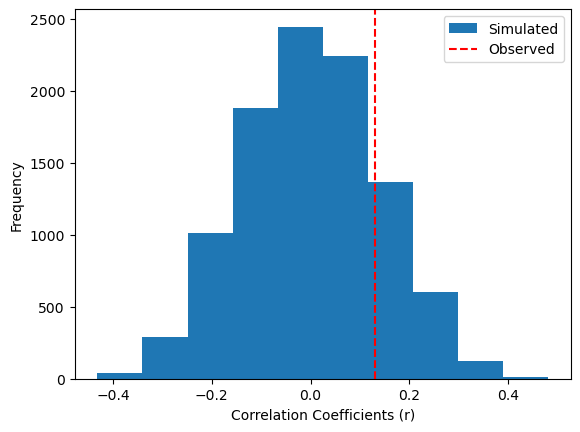

In [16]:
plt.hist(rSim,label='Simulated');
plt.axvline(r_real,linestyle='--',color='r',label='Observed');
plt.xlabel('Correlation Coefficients (r)')
plt.ylabel('Frequency');
plt.legend();

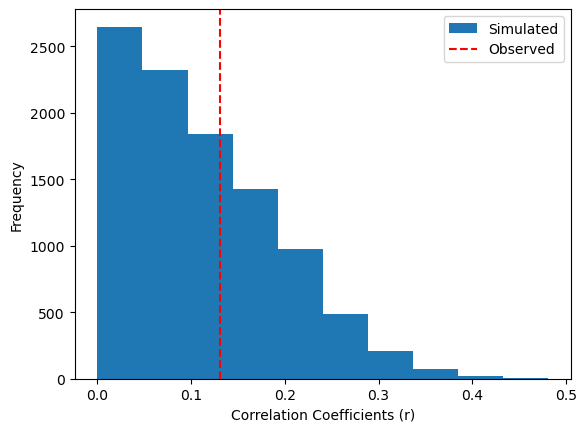

In [17]:
# Alternative way to visualize the two tailed test
plt.hist(np.abs(rSim),label='Simulated');
plt.axvline(np.abs(r_real),linestyle='--',color='r',label='Observed');
plt.xlabel('Correlation Coefficients (r)')
plt.ylabel('Frequency');
plt.legend();

We can see that our real value falls well within the distribution of the simulated correlations.   Indeed, random series with the same autocorrelation structure of our series but different phase can produce correlation values up to 0.40 just by chance (clowns, again).  

We might interpret this then as meaning that the observed correlation we calculated is not that unusual in the context of random (unrelated) series with similar autocorrelation structure.  

## Next steps

1. Be sure to review the Jupyter notebook `loops_in_python` in this same directory
Done!
2. What other ways could you imagine conducting a Monte Carlo simulation to test for significance (e.g. what other things might we be afraid of that we want to test?) - you should consult the documentation for the [`itertools`](https://docs.python.org/3/library/itertools.html), which provides many ways to iterate or loop.  What kind of simulations might you accomplish with some of these other tools? 
Might want to look at rain maps or other weather things to think about how spatial maps of rain across years are correlated. Obviously rain or a hurricane in one city means their neighbor also has a higher chance of rain. Could use the starmap function to make functions for false data in the monte carlo. Could also use cycle in a random function to randomly assign values between certain numbers. The permutations tool would be really good for that I think. Convolve is good for making timeseries or spatial series that look like each other I think?
3. Imagine a situation where you were correlated a single time series of data against a spatial dataset (e.g. National GDP vs. county-level GDP) - what other things might you be concerned about if you were interested in determining which counties were significant correlated with national GDP figures? 
Weighting by population or county area, specific seasonal things?